# Car Price prediction

**Цель проекта** - предсказать цену автомобиля

**Задачи**:
 - Подготовить набор данных для обучения модели
 - Потренировать работу с pandas на реальных данных
 - Попрактиковаться в построении различных моделий:
     - на основе градиентного бустинга с помощью CatBoost
     - на основе нейронных сетей
     - multi-input нейронную сеть для анализа табличных данных и текста одновременно
     - multi-input сеть для анализа табличных данных, текста и обработку изображений одновременно
     - ансамблирование градиентного бустинга и нейронной сети

**Общий план проекта**:
* ***Часть первая*** - *[SF Car Price 2] Emelyanov p.1 (EDA+CatBoost+NN1)*
* Построим "наивную" модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Построим первую модель на основе градиентного бустинга с помощью CatBoost
* Построим вторую модель на основе нейронных сетей и сравним результаты
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)
* ***Часть вторая (текущая)*** - *[SF Car Price 2] Emelyanov p.2 (NN1+NLP+CV)*
* Возьмем уже обработанные данные из первой части
* Построим multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга (из первой части) и multi-input нейронной сети (усреднение их предсказаний)



# Часть вторая

In [1]:
# tensorflow нужной версии
!pip install -q tensorflow==2.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# бибилиотека для аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
# библиотека для морфологического анализа русского языка 
!pip install pymorphy2
!pip install pymorphy2-dicts-ru

     |████████████████████████████████| 55 kB 733 kB/s 
     |████████████████████████████████| 8.2 MB 826 kB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# 1. Import

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
import math
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.feature_selection import f_classif, mutual_info_classif

from itertools import combinations
from scipy.stats import ttest_ind

# keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import albumentations

# nltk и morphy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# Уберем Warnings из отображения
import warnings; warnings.simplefilter('ignore')

# Поправим отображение дасетов
pd.set_option('display.max_columns', None)

# Добавим tqdm для более информативного отображения обработки данных
from tqdm.notebook import tqdm
tqdm.pandas()

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [6]:
!pip freeze > requirements.txt

**МЕТРИКА**

Определим метрику для проверки моделей - MAPE (Mean Percentage Absolute Error, расшифровывается выражение как средняя абсолютная ошибка в процентах).

In [7]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# 2. Setup

In [8]:
VERSION    = 19 # версия запуска для сохранения ответов

# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

RUSSIAN_STOPWORDS = set(stopwords.words('russian'))

# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

DATA_DIR        = '/kaggle/input/sf-dst-car-price-prediction-part2/'
FILE_TRAIN      = 'train.csv'
FILE_TEST       = 'test.csv'
FILE_SUB        =  'sample_submission.csv'

DATA_SAVED_DIR  = '/kaggle/input/sfdstcarpricepredictionpart2clearedprepared/'
DATA_SAVE       = 'sf-dst-car-price-prediction-part2-data-save.csv'

MODEL_PATH       = '/kaggle/working/'
#DRIVE_MODEL_PATH = '/kaggle/working'

VAL_SIZE   = 0.15   # 15% для разделения выборки на обучающую и тестовую

# 3. Data

## Определим вспомогательные функции

In [9]:
def load_data_frames():
    # Выгружает три датасета
    train = pd.read_csv(DATA_DIR + FILE_TRAIN)
    test = pd.read_csv(DATA_DIR + FILE_TEST)
    sample_submission = pd.read_csv(DATA_DIR + FILE_SUB)
    
    return train, test, sample_submission

In [10]:
# Форматы данных в обучающем и тестовом датасетах не отлючаются - можно будет их объединить 
# без дополнительной обработки. Для удобства переименуем поля с русского языка на английский.

def rename_columns_train(train: pd.DataFrame) -> None: 
    # Переименуем названия признаков в train датасете
    train.columns = [
        'body_type', 'brand', 'color', 'description', 'engine_displacement',
        'engine_power', 'fuel_type', 'mileage', 'model_date', 'model_info', 'name',
        'number_of_doors', 'price', 'production_date', 'sell_id', 'vehicle_configuration',
        'vehicle_transmission', 'owners', 'ownership', 'pts', 'drive_type', 'wheel'
    ]
    
def rename_columns_test(test: pd.DataFrame) -> None: 
    # Переименуем названия признаков в test датасете
    test.columns = [
        'body_type', 'brand', 'color', 'description', 'engine_displacement',
        'engine_power', 'fuel_type', 'mileage', 'model_date', 'model_info', 'name',
        'number_of_doors', 'production_date', 'sell_id', 'vehicle_configuration',
        'vehicle_transmission', 'owners', 'ownership', 'pts', 'drive_type', 'wheel'
    ]   

In [11]:
def concatenate_data_frames(train: pd.DataFrame, test: pd.DataFrame) -> pd.DataFrame:
    # ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
    columns = [
        'body_type', 'brand', 'color', 'description', 'engine_displacement',
        'engine_power', 'fuel_type', 'mileage', 'model_date', 'model_info', 'name',
        'number_of_doors', 'production_date', 'sell_id', 'vehicle_configuration',
        'vehicle_transmission', 'owners', 'ownership', 'pts', 'drive_type', 'wheel'
    ]
    
    df_train = train[columns]
    df_test = test[columns]

    df_train['price'] = train['price']  # Целевая переменная трейна
    df_test['price'] = 0                # Целевой переменной теста нет, поэтому занулим пока
    
    df_train['sample'] = 1 # помечаем где у нас трейн
    df_test['sample'] = 0  # помечаем где у нас тест

    return df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
def data_full_info(data, full=True, short=False) -> None:
    '''Функция для вывода общей информации по датасету.
    data - набор исходных данных
    full - флаг вывода информации для количественных признаков
    short - флаг вывода информации из первых трех строк датасета
    
    Функция для выводит общую информацию по датасету.
    
    Если установлен флаг short, то отобразить первые три строки из датасета.
    В ином случае - не отображать.
    
    
    Если установлен флаг full, то отобразить информацию для количественных признаков.
    В ином случае - не отображать.
    '''
        
    list_of_names = list(data.columns)
    temp_dict = {}
    temp_dict['имя признака'] = list_of_names
    temp_dict['тип'] = data.dtypes
    temp_dict['# значений'] = data.describe(include='all').loc['count'].astype(int)
    temp_dict['# пропусков(NaN)'] = data.isnull().sum().values 
    temp_dict['# уникальных'] = data.nunique().values
    
    if not short:
        temp_dict['в первой строке'] =data.loc[0].values
        temp_dict['во второй строке'] = data.loc[1].values
        temp_dict['в третьей строке'] = data.loc[2].values
        
    if full :
        temp_dict['минимум'] = data.describe(include='all').loc['min']
        temp_dict['среднее'] = data.describe(include='all').loc['mean']
        temp_dict['макс'] = data.describe(include='all').loc['max']
        temp_dict['медиана'] = data.describe(include='all').loc['50%']
        
    temp_df = pd.DataFrame.from_dict(temp_dict, orient='index')
    display(temp_df.T)

    return

In [13]:
def column_info(data: pd.DataFrame, column: str) -> None:
    '''Функция для вывода информации для номинативных признаков.
    data - набор исходных данных
    column - наименование признака
    
    Функция производит расчет ключевых значений номинативного признака и выводит их в stdout.
    
    '''
    
    n = 10 # Параметр для оценки наиболее часто встречающихся значений
    print(f'Проведем анализ для переменной {column}')
    
    print('Тип данных: ', data[column].dtype)
    print('Всего значений:', data.shape[0])
    print('Пустых значений:', data.shape[0] - data[column].notnull().sum())
    print(f'Значений, упомянутых более {n} раз:', (data[column].value_counts() > n).sum())
    print('Уникальных значений:', data[column].nunique())
      
    display(pd.DataFrame(data[column].value_counts()).head(10))
    

def plot_column_info(data: pd.DataFrame, column: str) -> None:  
    '''Функция для вывода информации для колличественных переменных.
    data - набор исходных данных
    column - наименование признака
    
    Функция производит расчет ключевых значений колличественного признака.
    Определяет наличие выбросов. Выводит полученные данные в stdout. 
    Риует гистограмму исходных значений и значениий ограниченных границами выбросов IQR.
    
    '''
    
    max_value = data[column].max()
    min_value = data[column].min()
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
    IQR = perc75 - perc25
    lower_limt = perc25 - 1.5*IQR
    upper_limit = perc75 + 1.5*IQR

    if max_value <= upper_limit and min_value >= lower_limt:
        outliers_status = 'Выбросов Нет.'
    else:
        outliers_status = 'Есть выбросы.'

    print('Всего значений:', data.shape[0])
    print('Пустых значений:', data.shape[0] - data[column].notnull().sum())
    
    print('25-й перцентиль: {}, 75-й перцентиль: {}, IQR: {},'.format(perc25, perc75, IQR))
    print(f'Границы значений: [{min_value}, {max_value}],')
    print('Границы выбросов: [{f}, {l}].'.format(f=lower_limt, l=upper_limit))
    print(outliers_status)
    
    plt.rcParams['figure.figsize'] = (10,7)
    
    data[column].loc[data[column].between(lower_limt, upper_limit)].hist(bins=20,
                                                                         range=(min_value, max_value), 
                                                                         label='IQR')

    data[column].hist(alpha=0.5, 
                      bins=20, 
                      range=(min_value, max_value), 
                      label='Исходные значения')

    plt.legend();

In [14]:
def plot_column_info_log(data: pd.DataFrame, column: str) -> None:  
    '''Функция для вывода информации для колличественных переменных.
    data - набор исходных данных
    column - наименование признака
    
    Функция производит расчет ключевых значений колличественного признака.
    Определяет наличие выбросов. Выводит полученные данные в stdout. 
    Риует гистограмму исходных значений, boxplot исходных значений, гистограмму логарифма исходных значений 
    и boxplot для них.
    
    '''
    
    max_value = data[column].max()
    min_value = data[column].min()
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
    IQR = perc75 - perc25
    lower_limt = perc25 - 1.5*IQR
    upper_limit = perc75 + 1.5*IQR
    
    if max_value <= upper_limit and min_value >= lower_limt:
        outliers_status = 'Выбросов Нет.'
    else:
        outliers_status = 'Есть выбросы.'
    
    outliers_num = data.query(f'{column} < {lower_limt} or {column} > {upper_limit}').shape[0]
    
    print('Всего значений:', data.shape[0])
    print('Пустых значений:', data.shape[0] - data[column].notnull().sum())
    
    print('25-й перцентиль: {}, 75-й перцентиль: {}, IQR: {},'.format(perc25, perc75, IQR))
    print(f'Границы значений: [{min_value}, {max_value}],')
    print('Границы выбросов: [{f}, {l}].'.format(f=lower_limt, l=upper_limit))
    print(outliers_status)
    print('Количество выбросов:', outliers_num)
    
    plt.rcParams['figure.figsize'] = (12,4)
    
    ser_iqr = data[column].loc[data[column].between(lower_limt, upper_limit)]
    ser_act = data[column]
    ser_log = data[column].apply(lambda x: math.log(x + 1))
    
    fig = plt.figure()
    st = fig.suptitle(f'Гистограммы и box-plot для признака \'{column}\' и log(\'{column}\')', fontsize='x-large')
    
    ax_1 = fig.add_subplot(1, 4, 1)
    ax_2 = fig.add_subplot(1, 4, 2)
    ax_3 = fig.add_subplot(1, 4, 3)
    ax_4 = fig.add_subplot(1, 4, 4)
    
    ax_1.hist(ser_act, bins=15)
    ax_1.set_title(f'\'{column}\'', loc = 'right', fontsize=10)
    ax_1.spines['top'].set_visible(False)
    ax_1.spines['right'].set_visible(False)
    
    ax_2.boxplot(ser_act)
    ax_2.set_title(f'boxplot of \'{column}\'', loc = 'left', fontsize=10)
    ax_2.spines['top'].set_visible(False)
    ax_2.spines['right'].set_visible(False)
    ax_2.spines['bottom'].set_visible(False)
    ax_2.spines['left'].set_visible(False)
    
    ax_3.hist(ser_log, bins=15)
    ax_3.set_title(f'log(\'{column}\')', loc = 'right', fontsize=10)
    ax_3.spines['top'].set_visible(False)
    ax_3.spines['right'].set_visible(False)
    
    ax_4.boxplot(ser_log)
    ax_4.set_title(f'boxplot of log(\'{column}\')', loc = 'left', fontsize=10)
    ax_4.spines['top'].set_visible(False)
    ax_4.spines['right'].set_visible(False)
    ax_4.spines['bottom'].set_visible(False)
    ax_4.spines['left'].set_visible(False)
    
    
    # shift subplots down:
    st.set_y(0.99)
    fig.subplots_adjust(top=0.85)
    
    plt.legend()
    plt.show();

In [15]:
def replace_nan(data_in: pd.DataFrame, column: str, typ: str, new_value='') -> pd.DataFrame:
    '''Функция возвращает датасет, в котором произведена замена пустых значений признака и добавлен новый
    признак, в котором сохраняется информаця о том, в какой строке было пустое значение
    data_in - набор исходных данных
    column - наименование признака
    typ - тип замены, может принимать значения: 'mode', 'median', 'mean', 'new_value'
    
    Создается новый признак с наименованием (column)_isnan, в котором сохраняется информаця 
    о том, в какой строке пустое значение признака (column)
    В зависимости от типа замены (typ) функция определяет значение, 
    на которое будет производится замена.
    Все значения признака (column) в наборе данных (data_in) заменяются на вычисленное значение.
    Функция возращает откорректированный набор данных, изменений в исходном наборе нет.
    
    '''
    
    data = data_in.copy()
    
    print(f'В новый признак \'{column}_isnan\' охраняем информацию, в каком наблюдении указано NaN')
    data.loc[:, column + '_isnan'] = pd.isna(data[column]).astype('uint8')
    
    if typ == 'mode':
        m = data.loc[:, column].mode()[0]
        s = 'самым распространенным значением '
    elif typ == 'median':
        m = data.loc[:, column].median()
        s = 'медианой'
    elif typ == 'mean':
        m = data.loc[:, column].mean()
        s = 'средневзвешенным значением'
    elif typ == 'new_value':
        m = new_value
        s = 'указанным значением'
    else:
        return None
    
    print(f'Заполним пустые значения признака {column} {s} {m}')
    data.loc[:, column] = data[column].fillna(m)
    
    return data

In [16]:
def get_stat_dif(data: pd.DataFrame, column: str, target: str) -> bool:
    '''Функция определяет, есть ли статистически значимые различия для признака.
    data - набор исходных данных
    column - наименование признака
    target - наименование целевого признака
    
    Функция проверяет, есть ли статистическая разница в распределении целевого признака (target)
    по номинативному признаку (column) в наборе данных (data). 
    Проверка осуществляется с помощью теста Стьюдента. 
    Проверяется нулевая гипотеза о том, что распределения целевого признака (target)
    по различным парам значений номинативного признака (column) неразличимы.
    Пары определяются из различных комбинаций n самых часто встречающихся занчений признака (column).
    Если различия найдены, то информация об этом выводится в stdout.
    
    '''
    
    n = 10 # Параметр для оценки наиболее часто встречающихся значений
    cols = data.loc[:, column].value_counts().index[:n]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data.loc[data.loc[:, column] == comb[0], target], 
                     data.loc[data.loc[:, column] == comb[1], target]).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для признака', column)
            return True
    
    return False

In [17]:
# вспомогательная функция для обработки признака engineDisplacement

def search_engine_displacement(text: str) -> float:
    pattern = '\d\.\d'
    match = re.findall(pattern, str(text))
    n = len(match)
    
    if n == 2:
        return float(match[1])
    elif n == 1:
        return float(match[0])
    else:
        return .0

In [18]:
# вспомогательная функция для обработки признака color

def color_is_popular(text: str) -> int:
    if text in ['чёрный']:
        return 4
    elif text in ['белый']:
        return 3
    elif text in ['серый', 'синий']:
        return 2
    elif text in ['серебристый', 'коричневый', 'красный']:
        return 1
    else:
        return 0

In [19]:
# вспомогательная функция для обработки признака description

def clean_description(text):
    """
    Receives a raw text and clean it using the following steps:
    1. Remove all non-words
    2. Transform the review in lower case
    3. Remove all stop words
    4. Perform morphing

    Args:
        review: the review that iwill be cleaned
    Returns:
        a clean review using the mentioned steps above.
    """
    
    patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
    
    text = re.sub(patterns, ' ', text)
    text = text.lower()
    text = word_tokenize(text)
    
    morph = MorphAnalyzer()
    text = [morph.parse(word)[0].normal_form for word in text if word not in RUSSIAN_STOPWORDS]
    text = " ".join(text)
    
    return text

In [20]:
# Создадим в блок предобработки данных. 
# Объединим всю предобработку признаков в единую функцию.
def clear_and_prepare_data(data_in: pd.DataFrame) -> pd.DataFrame:
    data = data_in.copy()
    
    # 1. Почистим данные, уберем пропуски.   
    # Заполним пропуски в поле owners самым распространенным значением
    data = replace_nan(data, 'owners', 'mode')
    # Доля пустых значений в поле ownership очень большая, мы не можем полагаться на значения данного поля - удалим
    data = data.drop(['ownership'], axis=1)
    
    # 2. Обработаем остальные признаки и создадим новые
    # В body_type оставим только внедорожник, седан, лифтбек и т.д. без доп.информации
    data.loc[:, 'body_type'] = data['body_type'].apply(lambda x: x.split(' ')[0].lower())

    # Добавим новый признак - степень популятности цвета    
    data.loc[:, 'color_is_popular'] = data['color'].apply(color_is_popular)
    
    # вынесем существенную информацию и преобразуем значения в численный формат
    data.loc[:, 'engine_displacement'] = data['engine_displacement'].apply(search_engine_displacement)
    
    # Поле engine_power представлено в виде "306 N12", нам надо только число Л.С.
    data.loc[:, 'engine_power'] = data['engine_power'].apply(lambda x: int(x.split(' ')[0]))    
    # Возьмем логарифм от признака engine_power
    data.loc[:, 'engine_power_log'] = np.log(data['engine_power'] + 1)
    
    # Добавим новый признак - возьмем логарифм от признака mileage
    data.loc[:, 'mileage_log'] = np.log(data['mileage'] + 1)
    
    # Добавим новый признак - возьмем логарифм от возраста модели (по model_date)
    data.loc[:, 'model_date_log'] = np.log(2020 - data['model_date'] + 1)
    
    # model_info == None для одного значения, заполним его тем же значением, что и для других записей с тем же наименованием
    index = data.query('model_info == "None"').index
    name = data.query('model_info == "None"')['name'].values[0]
    data.loc[index, 'model_info'] = data.query(f'name == "{name}"')['model_info'].mode()[0]
    
    # Добавим несколько признаков, которые соответствуют появлению ключевых значений в признаке 'name'
    patterns = ['xDrive', 'AMG', 'Long', 'BlueTEC']
    for pattern in patterns:
        data.loc[:, f'name_{pattern}'] = data['name'].apply(lambda text: 1 if len(re.findall(pattern, str(text).replace('длинный', 'Long'))) else 0)
    
    # Добавим новый признак - возьмем логарифм от возраста автомобиля (по model_date)
    data.loc[:, 'production_date_log'] = np.log(2020 - data['production_date'] + 1)
    
    # Добавим признак - разницу между production_date и model_date
    data.loc[:, 'delta_date'] = data['production_date'] - data['model_date']
    # Возьмем логарифм от признака
    data.loc[:, 'delta_date_log'] = np.log(data['production_date'] - data['model_date'] + 1)
    
    #
    data.loc[:, 'model_age'] = (2020 - data['model_date'] + 1)
    
    # Добавим признак - количество пройденных миль в год
    data.loc[:, 'mile_per_year'] = data['mileage'] / (2020 - data['production_date'] + 1)
    # Возьмем логарифм от признака
    data.loc[:, 'mile_per_year_log'] = np.log(data['mileage'] / (2020 - data['production_date'] + 1))
    
    # преобразуем значения в численный формат
    data.loc[:, 'owners'] = data['owners'].apply(lambda x: int(x[:1]))
    
    # Возьмем логарифм от целевого признака
    data.loc[:, 'price_log'] = np.log(data['price'] + 1)
    
    # Добавим обработку признака description
    data.loc[:, 'description_norm'] = data['description'].progress_apply(lambda text: clean_description(text))
    
    return data

In [21]:
def get_columns():
    cat_cols = [
        'body_type', 'brand', 'color', 'fuel_type', 'model_info', 
        'vehicle_transmission', 'drive_type'
    ]
    bin_cols = [
        'name_xDrive', 'name_AMG', 'name_Long', 'name_BlueTEC', 'pts'
    ]
    num_cols = [
        'engine_power', 'mileage_log', 'number_of_doors', 'production_date_log',
        'owners', 'color_is_popular', 'delta_date_log', 'mile_per_year', 'engine_displacement', 'model_age'
    ]
    del_cols = [
        'name', 'vehicle_configuration', 'mileage', 'production_date',
        'model_date', 'engine_power_log', 'delta_date', 
        'model_date_log', 'wheel', 'owners_isnan', 'mile_per_year_log'
    ]
    info_cols = ['description', 'description_norm', 'sell_id']
    target_cols = ['price', 'price_log']
    
    return info_cols, bin_cols, cat_cols, num_cols, del_cols, target_cols


In [22]:
def prepare_data_before_split(data_in: pd.DataFrame, column_target: str):
    '''includes several functions to pre-process the predictor data.'''
    
    data = data_in.copy()
    info_cols, bin_cols, cat_cols, num_cols, del_cols, target_cols = get_columns()
    
    # Суммарное количество признаков должно быть на одно меньше, чем в тамблице (не учитываем sample)
    columns_check =  len(cat_cols + bin_cols + num_cols + del_cols + info_cols + target_cols) + 1
    print(f'Суммарное количество признаков {columns_check} должно совпадать с размерностью тамблицы {data.shape[1]}')
    
    ############## Numerical Features ##############
    # Стандартизация числовых переменных  
    #scaler = MinMaxScaler()
    scaler = RobustScaler() # применим именно эту стандартизацию,тк она устойчива к выбросам
    for column in num_cols:
        data[column] = scaler.fit_transform(data[[column]])[:,0]
        
    # ############## Categorical Features ############## 
    # Применим подход Label Encoding для категориальных признаков
    for column in cat_cols:
        data[column] = data[column].astype('category').cat.codes
    # сделаем тоже самое для бинарных признаков, 
    for column in bin_cols:
        data[column] = data[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    data = pd.get_dummies(data, columns=cat_cols, dummy_na=False)

    # ############## Split train and submition data ############## 
    X = data.query('sample == 1').drop(columns=info_cols + del_cols + target_cols + ['sample'])
    X_sub = data.query('sample == 0').drop(columns=info_cols + del_cols + target_cols + ['sample'])
    y = data.query('sample == 1')[column_target]
    
    return X, X_sub, y

## Загрузим и подготовим все данные

In [23]:
# Загрузим данные
train, test, sample_submission = load_data_frames()

In [24]:
%%script false --no-raise-error

# Согласуем наименования признаков
rename_columns_train(train)
rename_columns_test(test)

# Объединим датасеты в один
data = concatenate_data_frames(train, test)

# Обработаем признаки - почистим данные и добавим новые признаки
data = clear_and_prepare_data(data)

# Сохраним данные
data.to_csv(DATA_SAVE, index=True, index_label = 'id')

# Для загрузки сохраненных файлов можно использовать 
# data_new = pd.read_csv(DATA_SAVE, index_col='id')

Выше представлен блок для загрузки и очистки данных. Но работает он 33 минуты в частности из-за морфологического анализа признака 'description' поэтому обработанные данные были вынесены в отдельный датасет для ускорения работы.

In [25]:
# Загрузим уже обработанные данные
data = pd.read_csv(DATA_SAVED_DIR + DATA_SAVE, index_col='id')

In [26]:
# сделаем предобработку
X, X_sub, y = prepare_data_before_split(data, 'price')

# Разобъем выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

Суммарное количество признаков 39 должно совпадать с размерностью тамблицы 39


# 4. Model 2: CatBoostRegressor

In [27]:
model = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          #learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, np.log(y_train),
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

Learning rate set to 0.023474
0:	learn: 0.0418738	test: 0.0419445	best: 0.0419445 (0)	total: 53.8ms	remaining: 4m 28s
100:	learn: 0.0130439	test: 0.0126795	best: 0.0126795 (100)	total: 353ms	remaining: 17.1s
200:	learn: 0.0104318	test: 0.0101208	best: 0.0101208 (200)	total: 630ms	remaining: 15s
300:	learn: 0.0098428	test: 0.0095939	best: 0.0095939 (300)	total: 895ms	remaining: 14s
400:	learn: 0.0094468	test: 0.0092849	best: 0.0092836 (398)	total: 1.16s	remaining: 13.3s
500:	learn: 0.0091039	test: 0.0090583	best: 0.0090577 (499)	total: 1.43s	remaining: 12.8s
600:	learn: 0.0087204	test: 0.0087965	best: 0.0087965 (600)	total: 1.7s	remaining: 12.4s
700:	learn: 0.0084028	test: 0.0085941	best: 0.0085941 (700)	total: 1.97s	remaining: 12.1s
800:	learn: 0.0081384	test: 0.0084558	best: 0.0084546 (799)	total: 2.25s	remaining: 11.8s
900:	learn: 0.0079194	test: 0.0083394	best: 0.0083394 (900)	total: 2.52s	remaining: 11.5s
1000:	learn: 0.0077287	test: 0.0082263	best: 0.0082263 (1000)	total: 2.8s	rem

In [28]:
#test_predict_catboost = model.predict(X_test)
test_predict_catboost = np.exp(model.predict(X_test))
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 11.18%


**Промежуточные итоги**

Метрики в различных вариантах моделей:
 - baseline - Test MAPE: 13.23%
 - предобработанные данные - Test MAPE: 11.18%

Что было сделано для улучшения модели и выводы:
 - Была выполнена предобработка данных. Как и ожидалось, метрика моделисущественно улучшилось по сравнению с baseline

Сделаем предсказание лучшей модели для тестовой выборки

In [29]:
sub_predict_catboost = np.exp(model.predict(X_sub))
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# 5. Model 3: Tabular NN

Построим обычную сеть для обработки табличных данных:

In [30]:
X_train.head(5)

,engine_displacement,engine_power,number_of_doors,owners,pts,color_is_popular,mileage_log,name_xDrive,name_AMG,name_Long,name_BlueTEC,production_date_log,delta_date_log,model_age,mile_per_year,body_type_0,body_type_1,body_type_2,body_type_3,body_type_4,body_type_5,body_type_6,body_type_7,body_type_8,body_type_9,body_type_10,body_type_11,body_type_12,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,color_13,color_14,color_15,fuel_type_0,fuel_type_1,fuel_type_2,fuel_type_3,model_info_0,model_info_1,model_info_2,model_info_3,model_info_4,model_info_5,model_info_6,model_info_7,model_info_8,model_info_9,model_info_10,model_info_11,model_info_12,model_info_13,model_info_14,model_info_15,model_info_16,model_info_17,model_info_18,model_info_19,model_info_20,model_info_21,model_info_22,model_info_23,model_info_24,model_info_25,model_info_26,model_info_27,model_info_28,model_info_29,model_info_30,model_info_31,model_info_32,model_info_33,model_info_34,model_info_35,model_info_36,model_info_37,model_info_38,model_info_39,model_info_40,model_info_41,model_info_42,model_info_43,model_info_44,model_info_45,model_info_46,model_info_47,model_info_48,model_info_49,model_info_50,model_info_51,model_info_52,model_info_53,model_info_54,model_info_55,model_info_56,model_info_57,model_info_58,model_info_59,model_info_60,model_info_61,model_info_62,model_info_63,model_info_64,model_info_65,model_info_66,model_info_67,model_info_68,model_info_69,model_info_70,model_info_71,model_info_72,model_info_73,model_info_74,model_info_75,model_info_76,model_info_77,model_info_78,model_info_79,model_info_80,model_info_81,model_info_82,model_info_83,model_info_84,model_info_85,model_info_86,model_info_87,model_info_88,model_info_89,model_info_90,model_info_91,model_info_92,model_info_93,model_info_94,model_info_95,model_info_96,model_info_97,model_info_98,model_info_99,model_info_100,model_info_101,model_info_102,model_info_103,model_info_104,model_info_105,model_info_106,model_info_107,model_info_108,model_info_109,model_info_110,model_info_111,model_info_112,model_info_113,model_info_114,model_info_115,model_info_116,model_info_117,model_info_118,model_info_119,model_info_120,vehicle_transmission_0,vehicle_transmission_1,vehicle_transmission_2,vehicle_transmission_3,drive_type_0,drive_type_1,drive_type_2
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7320,3.2,2.565574,0.0,-0.5,1,0.0,0.295786,0,0,0,0,0.254885,0.415037,0.428571,0.264848,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
8037,-0.8,0.114754,1.0,-0.5,1,-0.5,-1.603192,0,0,0,0,-1.120348,0.000000,-0.714286,-0.726306,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4681,0.3,0.196721,0.0,0.5,1,0.5,0.186252,0,0,0,0,0.718025,0.000000,1.000000,-0.485814,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
6014,-1.0,-0.385246,0.0,0.5,1,-0.5,1.056264,0,0,0,0,0.639218,-0.584963,0.714286,1.324238,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0

## Simple Dense NN

In [31]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="sigmoid")) # tanh sigmoid relu
model.add(L.Dropout(0.5))
model.add(L.Dense(512, activation="relu"))
model.add(L.Dense(512, activation="relu")) #добавили допонительный полносвязный слой
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               92160     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 617,985
Trainable params: 617,985
Non-trainable params: 0
__________________________________________________

In [33]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(
    loss='MAPE',
    optimizer=optimizer, 
    metrics=['MAPE']
)

### Коллбэки

Определим коллбэки для нашей будущей модели. В частности добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [34]:
checkpoint = ModelCheckpoint(
    filepath=MODEL_PATH+'best_model.hdf5', 
    monitor='val_MAPE', 
    save_best_only=True,
    verbose=0,
    mode='min'
)
earlystop = EarlyStopping(
    monitor='val_MAPE', 
    patience=50, 
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_MAPE', 
    factor=0.5, 
    min_lr=1e-5, 
    patience=10, 
    verbose=1
)
callbacks_list = [checkpoint, earlystop, reduce_lr]

### Fit

In [35]:
history = model.fit(
    X_train, y_train,
    batch_size=512,
    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
    validation_data=(X_test, y_test),
    callbacks=callbacks_list,
    verbose=0,
)


Epoch 00107: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 00135: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.

Epoch 00159: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00191: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00201: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00211: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00221: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.
Restoring model weights from the end of the best epoch.

Epoch 00231: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.
Epoch 00231: early stopping


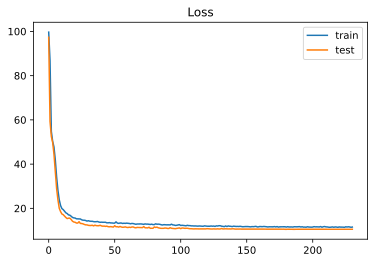

In [36]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.legend()
plt.show();

In [37]:
model.load_weights(MODEL_PATH + 'best_model.hdf5')
model.save(MODEL_PATH + 'nn_1.hdf5')

In [38]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 10.51%


**Промежуточные итоги**

Метрики в различных вариантах моделей:
 - baseline - Test MAPE: 14.24%
 - предобработанные данные, activation 'relu'     - Test MAPE: 11.07%
 - предобработанные данные, activation 'tanh'     - Test MAPE: 12.07% 
 - предобработанные данные, activation 'sigmoid'  - Test MAPE: 11.35% 
 - +1 Dense Layer, activation 'relu'     - Test MAPE: 10.86%
 - +1 Dense Layer, activation 'tanh'     - Test MAPE: 10.88%
 - +1 Dense Layer, activation 'sigmoid'  - Test MAPE: 10.77%
 - +1 Dense Layer 512, activation 'sigmoid'  - Test MAPE: 10.55%


Что было сделано для улучшения модели и выводы:
 - Была выполнена предобработка данных. В части предобработки данных:
  - была выполнена нормализация некоторых признаков
  - из некоторых категориальных признаков ('engineDisplacement', 'enginePower') были извлечены числовые значения
  - из признака 'name' была извлечена информация о наличии 'xDrive', 'AMG', 'Long', 'BlueTEC' и была сохранена в соответствующих новых признаках
  - часть категориальных признаков ('name' и др) была убрана, так как информация в них была составная и уже была учтена в других признаках
  - также были добавлены новые признаки
 - Была проверено несколько вариантов архитектуры сети и опробованы различные функции активации
 - Были иначе по сравнению с baseline определены  коллбэки для нашей модели

Выводы:
 - Как и ожидалось, после предобработки данных метрика моделисущественно улучшилось по сравнению с baseline
 - Добавление дополнительного полносвязного слоя, увеличение входов и подбор функции активации еще сильнее улучшили метрику модели

Сделаем предсказание лучшей модели для тестовой выборки

In [39]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

# 6. Model 4: NLP + Multiple Inputs

В baseline сеть для обработки текста - признака 'description' строилась без предварительной обработки данного признака. 

Для улчшения метрики модели произведем обработку признака 'description'. Для каждого значения выполним:
 1. Удалим все, что не является словами (Remove all non-words)
 2. Переведем все буквы текста в нижний регистр (Transform in lower case)
 3. Уберем все стоп-слова (Remove all stop words)
 4. Произведем морфолигеский разбор слов в тексте (Perform morphing)

 Все дейсвтия упакованы в функцию **clean_description()** и проделаны с признаком 'description'. Результат сохранен в новом признаке 'description_norm'.

In [40]:
data['description_norm']

id
0       весь привет продать эксклюзивный проект универ...
1       продавать любимый тачил обвес тюнинг ездить до...
2       машина продаваться первый перебрать двигатель ...
3       автомобиль отличный состояние весь родный крас...
4       немка бесключивый доступ камера задний вид авт...
                              ...                        
8348    продаваться любимый автомобиль год эксплуатаци...
8349    купить официальный дилер г третий владелец вла...
8350    торг место работать сборка немецкий резина лет...
8351    автомобиль отличный состояние авто семья обслу...
8352    удлинённый заводский база вообще правильно зав...
Name: description_norm, Length: 8353, dtype: object

In [41]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [42]:
# split данных
text_train = data['description_norm'].astype('str').iloc[X_train.index]
text_test = data['description_norm'].astype('str').iloc[X_test.index]
text_sub = data['description_norm'].astype('str').iloc[X_sub.index]

### Tokenizer

In [43]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.43 s, sys: 1.38 ms, total: 1.44 s
Wall time: 1.43 s


In [44]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.08 s, sys: 720 µs, total: 1.08 s
Wall time: 1.08 s


In [45]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

• автомобиль проверить пункт • автокредит специальный ставка ауди центр север официальный дилер входящий группа компания рольф являться один крупный дилер европа предлагать ряд услуга покупка продажа автомобиль пробег протяжение многий год наш дилерский центр являться лидер продажа автомобиль пробег среди дилер россия предоставлять клиент самый большой выбор автомобиль пробег другой марка каждый автомобиль проходить тщательный диагностик подготовка гарантировать находиться отличный состояние убедиться правильный выбор возможность пройти тест драйв ― ознакомительный поездка интересовать автомобиль смочь ознакомиться автомобиль выходить дом – наш менеджер провести презентация видеозвонок показать выбрать автомобиль также ауди центр север представлять уникальный предложение кредитование автомобиль пробег индивидуальный условие специалист компания подобрать хороший условие кредитование проверить автомобиль пробег гарантия год ждать сайт мобильный приложение рольф
[    0     0     0     0  

### RNN NLP

Построим модель для обработки текста 

In [46]:
# Модель для обработки текста без головы
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(512, return_sequences=True))
model_nlp.add(L.Dropout(0.5)) 
model_nlp.add(L.LSTM(256,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(256, activation="relu")) 
model_nlp.add(L.Dense(128, activation="relu"))  
model_nlp.add(L.Dropout(0.25))

### MLP

Построим модель для обработки табличных данны  - за основу возьмем уже подготовленную модель без головы и предыдущего раздела 

In [47]:
# Модель для обработки табличных данны без головы
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="tanh")) # tanh sigmoid relu
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(512, activation="relu")) #добавим полносвязный слой
model_mlp.add(L.Dense(512, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

Объединим общей головой модели для обработки текста и табличных данных 

In [48]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [49]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     10135552    seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 512)     1574912     embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 512)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

Обучим модель

In [50]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(
    loss='MAPE',
    optimizer=optimizer, 
    metrics=['MAPE']
)

In [51]:
checkpoint = ModelCheckpoint(
    filepath=MODEL_PATH+'best_model.hdf5', 
    monitor='val_MAPE', 
    save_best_only=True,
    verbose=0,
    mode='min'
)
earlystop = EarlyStopping(
    monitor='val_MAPE', 
    patience=50, 
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_MAPE', 
    factor=0.5, 
    min_lr=1e-5, 
    patience=10, 
    verbose=1
)
callbacks_list = [checkpoint, earlystop, reduce_lr]

In [52]:
#%%script false
history = model.fit(
    [text_train_sequences, X_train], y_train,
    batch_size=512,
    epochs=500, # 500 фактически мы обучаем пока EarlyStopping не остановит обучение
    validation_data=([text_test_sequences, X_test], y_test),
    callbacks=callbacks_list,
    verbose=0
)


Epoch 00070: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 00107: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.

Epoch 00117: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00139: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 00149: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00159: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 00169: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.
Restoring model weights from the end of the best epoch.

Epoch 00179: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.
Epoch 00179: early stopping


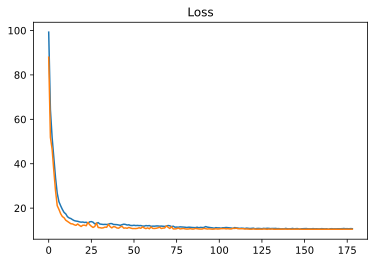

In [53]:
#%%script false
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [54]:
#%%script false
model.load_weights(MODEL_PATH + 'best_model.hdf5')
model.save(MODEL_PATH + 'nn_mlp_nlp.hdf5')

In [55]:
#%%script false
# Сохраним веса NN и NLP
model_nlp.save(MODEL_PATH + 'nn_mlp_nlp(nlp).hdf5')
model_mlp.save(MODEL_PATH + 'nn_mlp_nlp(mlp).hdf5')

In [56]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 10.47%


 **Промежуточные итоги**

Метрики в различных вариантах моделей:
 - baseline - Test MAPE: 14.23%
 - предобработанные данные (далее обр.данные) - Test MAPE: 10.86%
 - обр.данные, созданная ранее NN (далее NN1) + activation 'relu'     - Test MAPE: 10.84% 
 - обр.данные, NN1 + activation 'tanh'     - Test MAPE: 10.56%
 - обр.данные, NN1 + activation 'sigmoid'  - Test MAPE: 10.97% 
 - обр.данные, NN1 + activation 'relu', NLP layers 512, 256, 128     - Test MAPE: 10.78% 
 - обр.данные, NN1 + activation 'tanh', NLP layers 512, 256, 128     - Test MAPE: 10.52% 
 - обр.данные, NN1 + activation 'sigmoid', NLP layers 512, 256, 128  - Test MAPE: 10.88% 
 - обр.данные, NN1 + activation 'tanh', NLP layers 512, 256, 128 +1 Dense 128    - Test MAPE: 10.50%
 - обр.данные, NN1 + activation 'tanh', NLP layers 512, 256, 256 +1 Dense 128    - Test MAPE: 10.47% 




Что было сделано для улучшения модели и выводы:
 - Была выполнена предобработка данных. Помимо прочего была произведена лемматизация текста в признаке 'description'
 - Была проверено несколько вариантов архитектуры сети и опробованы различные функции активации
 - Были иначе по сравнению с baseline определены  коллбэки для нашей модели


Выводы:
 - Как и ожидалось, после предобработки данных (в частности очистки и лематизация текста) метрика моделисущественно улучшилось по сравнению с baseline
 - Добавление дополнительных полносвязных слоев в сети для обработки табличных данных и для обработки текста, увеличение входов и подбор функции активации еще сильнее улучшили метрику
 - Лучший вариант сети немного улушил метрику по сранению с сетью, которая обрабатывает только табличные данные. Следовательно, какие-то закономерности из признака 'description' сеть смогла вычленить и улучшить модельв целом.

Идеи для улучшения модели:
 - Поработать над функцией очистки clean_description() 
 - Подумать над возможностью аугментации текста
 - Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив (например, наличие слов 'гараж', 'подарок', 'торг', 'шины', 'дилер', 'подогрев', 'обмен', 'обслуж', 'срочн', 'полн', 'скидк','диск)

Сделаем предсказание лучшей модели для тестовой выборки

In [57]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

# 6. Model 5: Добавляем картинки

### Data

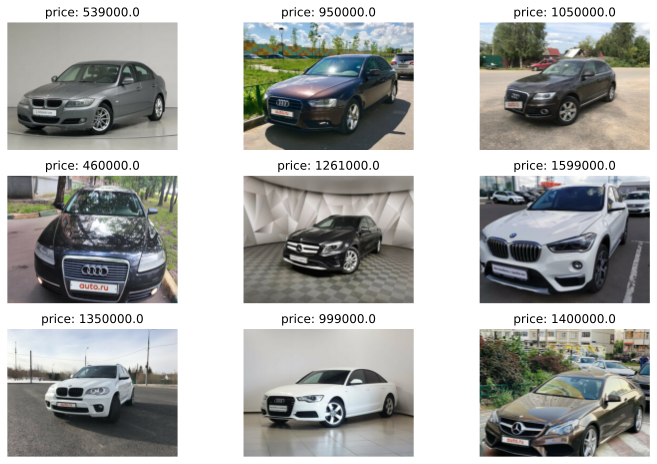

In [58]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [59]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

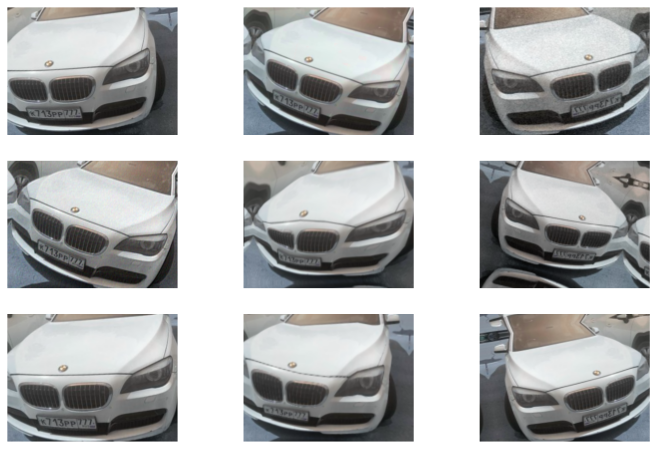

In [60]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [61]:
def make_augmentations(images):
    print('применение аугментаций', end = '')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end = '')
        augment_dict = augmentation(image = images[i])
        augmented_image = augment_dict['image']
        augmented_images[i] = augmented_image
    print('')
    return augmented_images

In [62]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [63]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [64]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights='imagenet', include_top=False, input_shape=(size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 1s 0us/step


In [65]:
# строим нейросеть для анализа табличных данных
tabular_model = Sequential()
tabular_model.add(L.Dense(512, input_dim=X_train.shape[1], activation="tanh")) # tanh sigmoid relu
tabular_model.add(L.Dropout(0.5))
tabular_model.add(L.Dense(512, activation="relu")) #добавим полносвязный слой
tabular_model.add(L.Dense(512, activation="relu"))
tabular_model.add(L.Dropout(0.5))

In [66]:
# строим нейросеть для анализа NLP
nlp_model = Sequential()
nlp_model.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
nlp_model.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
nlp_model.add(L.LSTM(512, return_sequences=True))
nlp_model.add(L.Dropout(0.5)) 
nlp_model.add(L.LSTM(256,))
nlp_model.add(L.Dropout(0.25))
nlp_model.add(L.Dense(256, activation="relu")) 
nlp_model.add(L.Dense(128, activation="relu"))  
nlp_model.add(L.Dropout(0.25))

In [67]:
# загрузим веса уже обученных моделей из предыдущего раздела
nlp_model.load_weights(MODEL_PATH + 'nn_mlp_nlp(nlp).hdf5')
tabular_model.load_weights(MODEL_PATH + 'nn_mlp_nlp(mlp).hdf5')

In [68]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [69]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(
    loss='MAPE',
    optimizer=optimizer, 
    metrics=['MAPE']
)

In [70]:
checkpoint = ModelCheckpoint(
    filepath=MODEL_PATH+'best_model.hdf5',
    monitor='val_MAPE', 
    save_best_only=True,
    verbose=0,
    mode='min'
)
earlystop = EarlyStopping(
    monitor='val_MAPE', 
    patience=50, 
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_MAPE', 
    factor=0.5, 
    min_lr=1e-5, 
    patience=10, 
    verbose=1
)
callbacks_list = [checkpoint, earlystop, reduce_lr]

In [71]:
#%%script false
history = model.fit(train_dataset.batch(30),
                    epochs=150, # 100
                    validation_data = test_dataset.batch(30), # 30
                    callbacks=callbacks_list,
                    verbose=1
                   )

Epoch 1/150
190/190 [==============================] - 151s 797ms/step - loss: 17.5001 - MAPE: 17.5001 - val_loss: 11.4667 - val_MAPE: 11.4667
Epoch 2/150
190/190 [==============================] - 148s 778ms/step - loss: 11.8671 - MAPE: 11.8671 - val_loss: 11.5229 - val_MAPE: 11.5229
Epoch 3/150
190/190 [==============================] - 149s 784ms/step - loss: 11.9843 - MAPE: 11.9843 - val_loss: 11.1495 - val_MAPE: 11.1495
Epoch 4/150
190/190 [==============================] - 147s 775ms/step - loss: 12.3847 - MAPE: 12.3847 - val_loss: 11.4500 - val_MAPE: 11.4500
Epoch 5/150
190/190 [==============================] - 149s 782ms/step - loss: 12.1143 - MAPE: 12.1143 - val_loss: 10.8920 - val_MAPE: 10.8920
Epoch 6/150
190/190 [==============================] - 150s 790ms/step - loss: 12.1529 - MAPE: 12.1529 - val_loss: 10.8004 - val_MAPE: 10.8004
Epoch 7/150
190/190 [==============================] - 146s 768ms/step - loss: 11.9260 - MAPE: 11.9260 - val_loss: 11.1948 - val_MAPE: 11.1948

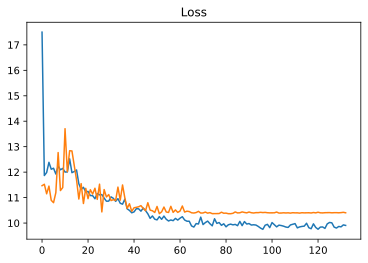

In [72]:
#%%script false
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [73]:
#%%script false
model.load_weights(MODEL_PATH + 'best_model.hdf5')
model.save(MODEL_PATH + 'nn_final.hdf5')

In [74]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 10.37%


 **Промежуточные итоги**

Метрики в различных вариантах моделей:
 - baseline - Test MAPE: 14.35%
 - предобработанные данные (далее обр.данные) - Test MAPE: 10.85% (3 ч 50 мин)
 - обр.данные, созданная ранее сеть NLP + Multiple Inputs (далее NLP + MLP) + activation 'tanh'     - Test MAPE: 10.51% 


Что было сделано для улучшения модели и выводы:
 - Была выполнена предобработка данных (для улучшения обработки табличных данных и текста). 
 - Были иначе по сравнению с baseline определены  коллбэки для нашей модели
 - Опробовал несколько вариантов архитектуры сетей и Fine-tuning, пробовал замораживать часть слоев и обучать только голову или обучать вторую часть и голову. Из всех вариантов оказался примелемым по времени такой вариант:
  - для обаботки табличных данных  и обработки текста берутся уже созданные ранее сети (без обработки изображений из прошлого раздела)
  - загружаем веса из уже обученной ранее модели (без обработки изображений из прошлого раздела)
  - для обработки изображений берем готовую сеть EfficientNetB3
  - дообучаем сеть в комплесе


Выводы:
 - Как и ожидалось, после предобработки данных метрика модели существенно улучшилось по сравнению с baseline
 - Изменение архитектуры и загруженные веса ранее уже обученной модели существенно повлияли на скорость улучшения метрики во время обучения (общее время на обучение не изменилось, но метрика улучшилась)
 - Лучший вариант сети немного ухудшил метрику по сранению с сетью, которая обрабатывает табличные данные и текст. Есть предположение, что какие-то закономерности из изображений сеть все-таки смогла вычленить. Проверим это на ансамблировании моделей.

Идеи для улучшения модели:
 - Поработать над аугментацией изображений
 - Можно добавить количество эпох обучения
 

Сделаем предсказание лучшей модели для тестовой выборки

In [75]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

# 7. Blend

Проведем Ансамблирование моделей. Усредним результаты предсказаний наших моделей.

In [76]:
blend_predict = (test_predict_catboost + test_predict_nn1[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.45%


In [77]:
blend_predict = (test_predict_catboost + test_predict_nn1[:,0] + test_predict_nn2[:,0])/3
print(f"TEST mape: {mape(y_test, blend_predict)*100:0.2f}%")

TEST mape: 10.29%


In [78]:
blend_predict = (test_predict_catboost + test_predict_nn1[:,0] + test_predict_nn2[:,0] + test_predict_nn3[:,0])/4
print(f"TEST mape: {mape(y_test, blend_predict)*100:0.2f}%")

TEST mape: 10.24%


**Промежуточные итоги**

Метрики в различных вариантах ансамбля моделей:
 - CatBoost + NN1 (Tabular) - TEST mape: 10.45%
 - CatBoost + NN1 + NLP - TEST mape: 10.28%
 - CatBoost + NN1 + NLP + CV- TEST mape: 10.26%

Выводы:
 -  При добавлении в ансамбль сети для обработки изображений метрика немного улучшилась. Следовательно, какие-то закономерности из изображений сеть все-таки смогла вычленить.
 - Лучший результат при ансамблировании всех моделей

Идеи для улучшения модели:
 - В текущей реализации ансамблирование моделей было осуществленно простым усредением. Можно подобрать коэффициенты для усреденения.
 - На будущее также можно проанализировать в каких случаях какая модель сильнее ошибается и у проводить усредение более аккуартно

Сделаем предсказание лучшего варианта ансамбля моделей для тестовой выборки

In [79]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn1[:,0] + sub_predict_nn2[:,0] + sub_predict_nn3[:,0]) / 4
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# 8. Results

Были подготовлены несколько моделей для пресказания цены автомоболиля:
 - Наивная модель, предсказывающая цену по модели и году выпуска 
 - Модель градиентного бустанга 
 - Нейросеть, которая обрабатывает только табличные данные
 - Нейросеть, которая обрабатывает табличные данные и текст
 - Нейросеть, которая обрабатывает табличные данные, текстовые данныые и изборажения
 - Для итогового ответа был использован ансамбль из всех моделей 

Метрика модели, определенная в рамках соревнования на kaggle, равна **10.74133 (8-е место)**.

Что было выполнено в рамках проекта:
 - За основу был взят baseline-проект

 - Была выполнена предобработка данных. В части предобработки данных:
  - была выполнена нормализация некоторых признаков
  - из некоторых категориальных признаков ('engineDisplacement', 'enginePower') были извлечены числовые значения
  - из признака 'name' была извлечена информация о наличии 'xDrive', 'AMG', 'Long', 'BlueTEC' и была сохранена в соответствующих новых признаках
  - часть категориальных признаков ('name' и др) была убрана, так как информация в них была составная и уже была учтена в других признаках
  - также были добавлены новые признаки
  - была произведена лемматизация текста в признаке 'description'

 - Были иначе по сравнению с baseline определены  коллбэки. Настройка callback в частности ModelCheckpoint чтобы сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель. (Ввиду ограничений на пользование ресурсами GPU и времязатратности самого просчета модели, большую часть вычислений производилось на платформе Google Colab.)ReduceLROnPlateau для калибровки LR в процессе обучения.

 - Была проверено несколько вариантов архитектуры сети для обработки табличных данных и опробованы различные функции активации
 - Была проверено несколько вариантов архитектуры сети для обработки текстовых данных и опробованы различные функции активации
 - Для сети с обработкой изображений опробовал несколько вариантов архитектуры сетей и Fine-tuning, пробовал замораживать часть слоев и обучать только голову или обучать вторую часть и голову. Из всех вариантов оказался примелемым по времени такой вариант:
  - для обаботки табличных данных  и обработки текста берутся уже созданные ранее сети (без обработки изображений из прошлого раздела)
  - загружаем веса из уже обученной ранее модели (без обработки изображений из прошлого раздела)
  - для обработки изображений берем готовую сеть EfficientNetB3
  - дообучаем сеть в комплесе

 - Посмотрел несколько вариантов ансамбля моделей

Что не было выполнено - идеи для улучшения моделей:
 - Поработать над функцией очистки clean_description() 
 - Подумать над возможностью аугментации текста
 - Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив (например, наличие слов 'гараж', 'подарок', 'торг', 'шины', 'дилер', 'подогрев', 'обмен', 'обслуж', 'срочн', 'полн', 'скидк','диск)
 - Поработать над аугментацией изображений
 - Можно добавить количество эпох обучения для сети с обработкой изображений
 - Попробовать различные подходы в управление LR и оптимизаторы
 - Можно попробовать осуществить проброс признаков
 - В текущей реализации ансамблирование моделей было осуществленно простым усредением. Можно подобрать коэффициенты для усреденения.